In [11]:
from PIL import Image
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from p5a import ReducingresolutionClass
from p5c import eval_resolution

In [3]:
# Load the images
images = [Image.open(f'{i}.jpg') for i in range(1, 11)]
reducing = ReducingresolutionClass(n=2)
features, labels, end_of_each_image, low_res_images =  reducing.reduce(images)
list_features = features
features = np.array(features)
labels = np.array(labels)

# Split the dataset into training, validation, and test sets
train_features, train_labels = features[:end_of_each_image[7]], labels[:end_of_each_image[7]]
val_features, val_labels = features[end_of_each_image[7]:end_of_each_image[8]], labels[end_of_each_image[7]:end_of_each_image[8]]
test_features, test_labels = features[end_of_each_image[8]:], labels[end_of_each_image[8]:]

In [7]:
# Check if a GPU is available and if not, use a CPU
from model_resolution import MLP, device
# Create the MLP
model = MLP().to(device)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Convert the datasets to PyTorch tensors and move them to the appropriate device
train_features = torch.tensor(train_features, dtype=torch.float32, requires_grad=True).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32, requires_grad=True).to(device)
val_features = torch.tensor(val_features, dtype=torch.float32, requires_grad=True).to(device)
val_labels = torch.tensor(val_labels, dtype=torch.float32, requires_grad=True).to(device)



In [73]:
# Initialize lists to store the losses
train_losses = []
val_losses = []

# Train the MLP
for epoch in range(10):  # 100 epochs
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Reset the gradients
    train_outputs = model(train_features)  # Forward pass
    loss = criterion(train_outputs, train_labels)  # Compute the loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    # Store the training loss
    train_losses.append(loss.item())

    # Print the loss for this epoch
    print(f'Epoch {epoch+1}/{100} - Training Loss: {loss.item()}')

    # Validate the MLP
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track the gradients
        val_outputs = model(val_features)  # Forward pass
        val_loss = criterion(val_outputs, val_labels)  # Compute the loss

        # Store the validation loss
        val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            # Print the validation loss
            print(f'Epoch {epoch+1}/{100} - Validation Loss: {val_loss.item()}')

# Plot the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()


Epoch 1/100 - Loss: 11442.35546875
Epoch 2/100 - Loss: 10745.9326171875
Epoch 3/100 - Loss: 10042.49609375
Epoch 4/100 - Loss: 9347.54296875
Epoch 5/100 - Loss: 8663.595703125
Epoch 6/100 - Loss: 7966.0205078125
Epoch 7/100 - Loss: 7256.9951171875
Epoch 8/100 - Loss: 6543.2666015625
Epoch 9/100 - Loss: 5834.6640625
Epoch 10/100 - Loss: 5138.53076171875
Validation Loss: 3093.09033203125


In [5]:
# Save the model
torch.save(model.state_dict(), 'model_part_b.pth')

NameError: name 'model' is not defined

In [9]:
# Convert the test dataset to PyTorch tensors and move them to the appropriate device
test_features = torch.tensor(test_features, dtype=torch.float32, requires_grad=True).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32, requires_grad=True).to(device)
# Calculate the error function value for the test dataset
model = MLP().to(device)
model.load_state_dict(torch.load('model_part_b.pth', map_location=device))
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track the gradients
    test_outputs = model(test_features)  # Forward pass
    test_loss = criterion(test_outputs, test_labels)  # Compute the loss

# Print the test loss
print(f'Test Loss: {test_loss.item()}')

# Generate high-resolution images
high_res_images = []
for i in end_of_each_image.keys():
    if i > 1:
        low_res_image_np = features[end_of_each_image[i-1]:end_of_each_image[i]]
    else:
        low_res_image_np = features[0:end_of_each_image[1]]# Convert PIL Image to numpy array
    low_res_image_tensor = torch.tensor(low_res_image_np, dtype=torch.float32, requires_grad=True).to(device)
    high_res_image = model(low_res_image_tensor).cpu().detach().numpy()
    high_res_images.append(high_res_image)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10980\4052113209.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_features = torch.tensor(test_features, dtype=torch.float32, requires_grad=True).to(device)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10980\4052113209.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels, dtype=torch.float32, requires_grad=True).to(device)


Test Loss: 48.31061553955078


In [12]:
# Compare the high-resolution images with the original images
eval_resolution(high_res_images, images)

Image 1 - SSIM: 0.06610252162243795, PSNR: 8.642263944995094
Image 2 - SSIM: 0.26410090673762193, PSNR: 11.152787317915552
Image 3 - SSIM: 0.1772294288374208, PSNR: 12.937517816638227
Image 4 - SSIM: 0.08568823801359245, PSNR: 11.04035195723952
Image 5 - SSIM: 0.07020355597619267, PSNR: 10.035674895254019
Image 6 - SSIM: 0.16090778630650265, PSNR: 10.446297435590846
Image 7 - SSIM: 0.04980054688865447, PSNR: 8.128980033692374
Image 8 - SSIM: 0.13731686291136833, PSNR: 12.871823778487608
Image 9 - SSIM: 0.036489336937605345, PSNR: 11.010545267432176
Image 10 - SSIM: 0.23041572448256117, PSNR: 10.864950370179674


In [13]:
# Convert the numpy array to integer type
high_res_images_quantized = []
for i, (high_res_img, img) in enumerate(zip(high_res_images, images)):
    high_res_img = high_res_img.reshape(img.height, img.width, 3).astype(np.uint8)
    high_res_image_ = high_res_img.astype(np.uint8)
    high_res_images_quantized.append(high_res_image_)

# Convert the numpy array to a PIL Image
high_res_images_pil = [Image.fromarray(img).convert('RGB') for img in high_res_images_quantized]

In [24]:
for high_res_images_pili in high_res_images_pil:
    high_res_images_pili.show()

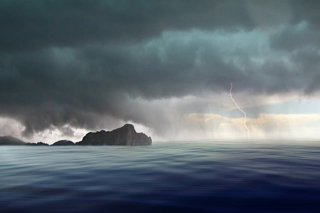

In [20]:
low_res_images[9]